In [13]:
## Parie 2-2

# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import math
import sklearn
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from sklearn.metrics import accuracy_score
import seaborn as sns; sns.set()  # for plot styling
from scipy.stats import mode
from time import time

In [15]:
X = np.load("./MNIST_X_28x28.npy")
y = np.load("./MNIST_y.npy")
X = X/255
n_digits = 10
n_clusters = 10
train_size = 0.7
n_components = 0.9

# Split/Flatten des images

In [16]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=1-train_size, random_state=42)

# Les données sont maintenant en 49000x784 au lieu de 49000x28x28
X_ftrain = X_train.flatten().reshape(X_train.shape[0], 784)
X_ftest  = X_test.flatten().reshape(X_test.shape[0], 784)
print(X_ftrain.shape, X_ftest.shape)

(48999, 784) (21001, 784)


# PCA

In [17]:
pca = PCA(n_components = n_components)
test = pca.fit(X_ftrain)
X_pca_train = pca.transform(X_ftrain)
X_pca_test = pca.transform(X_ftest)
print(X_pca_train.shape, X_pca_test.shape)
test.components_.shape

(48999, 87) (21001, 87)


(87, 784)

# KMeans

In [18]:
kmeans = KMeans(init='random', n_clusters = n_clusters)
kmeans.fit(X_pca_train)

clusters_kmeans = kmeans.predict(X_pca_test)
print(clusters_kmeans.shape)

(21001,)


In [19]:
print(clusters_kmeans)

[2 5 6 ... 0 4 4]


# Gaussian Mixture

In [20]:
Gauss = GaussianMixture(n_components = n_digits, covariance_type = 'full')
Gauss.fit(X_pca_train)

clusters_gauss = Gauss.predict(X_pca_test)
print(clusters_gauss.shape)

(21001,)


In [21]:
print(clusters_gauss)

[2 0 9 ... 3 5 5]


# Affichage des clusters en dimension 2

## KMEANS : 

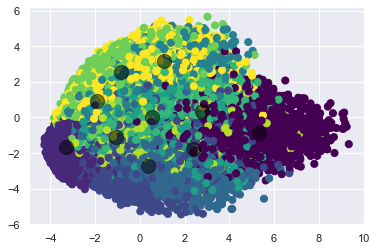

In [8]:
centers_p = kmeans.cluster_centers_
centers = pca.inverse_transform(centers_p)
centers = centers.reshape(n_clusters, 28, 28)

plt.scatter(X_pca_train[:, 0], X_pca_train[:, 1], c=y_train, s=50, cmap='viridis')
plt.scatter(centers_p[:, 0], centers_p[:, 1], c='black', s=200, alpha=0.5);
plt.show()

# Ajustement des labels pour correspondre au dataset


In [22]:
labels_kmeans = np.zeros_like(clusters_kmeans)
labels_gauss = np.zeros_like(clusters_gauss)
for i in range(n_digits):
    mask_kmeans = (clusters_kmeans == i)
    mask_gauss = (clusters_gauss == i)
    labels_kmeans[mask_kmeans] = mode(y_test[mask_kmeans])[0]
    labels_gauss[mask_gauss] = mode(y_test[mask_gauss])[0]

print(accuracy_score(y_test, labels_kmeans), accuracy_score(y_test, labels_gauss))

0.5805914004095043 0.6098281034236465


# Matrice de confusion

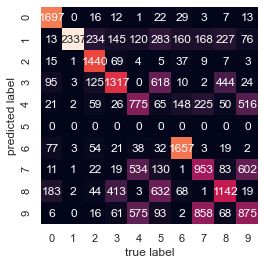

In [23]:
from sklearn.metrics import confusion_matrix
mat_kmeans = confusion_matrix(y_test, labels_kmeans)
sns.heatmap(mat_kmeans.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels="0123456789",
            yticklabels="0123456789")
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.show()

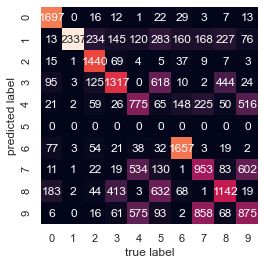

In [24]:
mat_gauss = confusion_matrix(y_test, labels_kmeans)
sns.heatmap(mat_gauss.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels="0123456789",
            yticklabels="0123456789")
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.show()

# Analyse des performances

In [73]:
def result(estimator, name, data, labels):
    t0 = time()
    estimator.fit(data)
    print(82 * '_')
    print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

In [74]:
kmeans = KMeans(init='random', n_clusters = n_clusters)
sample_size = 300
result(kmeans, 'random', X_ftrain, y_train)

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
random   	25.96s	124978086559	0.493	0.500	0.497	0.361	0.496	0.059


In [75]:
kmeans = KMeans(init='k-means++', n_clusters = n_clusters)
result(kmeans, 'kmeans++', X_ftrain, y_train)

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
kmeans++ 	30.83s	124978471968	0.492	0.500	0.496	0.362	0.496	0.052


In [76]:
result(kmeans, 'kmeans++/PCA', X_pca_train, y_train)

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
kmeans++/PCA	2.34s	3154737731	0.357	0.363	0.360	0.248	0.360	0.350
